In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper

In [32]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
train = pd.read_csv('train_geo.csv', index_col=0)

In [4]:
target = ['SalePrice']
key = ['PID'] 
numeric = ['GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea',
           'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold'
          ] 
## Let's say you wanted to classify 'YearBuilt' (for example) as ordinal. From a math point of view,
## does it make any difference?
numeric_to_categorical = ['MSSubClass','MoSold']

## Had to remove 'MasVnrType','Electrical','RoofMatl', 'Exterior1st','Exterior2nd', 'Utilities'
## because they get dropped later and am running these categorical through
## OneHotEncoder
categorical = ['MSZoning','Street','Alley','LotShape','LandContour','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
               'RoofStyle','Foundation', 'BsmtFinType1','BsmtFinType2','Heating','GarageType',
               'GarageFinish','PavedDrive','MiscFeature','SaleType','SaleCondition',
               'BedroomAbvGr', 'CentralAir'
              ]
## Moved 'BedroomAbvGr' to categorical for one-hot encoding. Moved 'CentralAir' to categorical because
## although binary was currently encoded as Y/N.
    
cat_ordinal = [
               'OverallQual','OverallCond', # numeric?
               'ExterQual','ExterCond', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'BsmtQual','BsmtCond', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'BsmtExposure', # {'No':1,'Mn':2,'Av':3,'Gd':4}
               'HeatingQC', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'BsmtFullBath','BsmtHalfBath', # numeric?
               'FullBath','HalfBath', # numeric?
               'KitchenAbvGr', # numeric?
               'KitchenQual', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'TotRmsAbvGrd', # numeric?
               'Functional', # {'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,
                             #  'Mod':5,'Min2':6,'Min1':7,'Typ':8}
               'Fireplaces', # numeric?
               'FireplaceQu', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'GarageCars', # numeric?
               'GarageQual', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'GarageCond', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'PoolQC', # {'Fa':1,'TA':2,'Gd':3,'Ex':4}
               'Fence' #{'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
               ]

## train cleaning

In [5]:
# converting all similar mappings together
# most popular mapping

## There is some imputing hidden in the convert_cat_ordinal function.

cat_ordinal_features = [
    'GarageQual','GarageCond',
    'FireplaceQu',
    'KitchenQual',
    'ExterQual','ExterCond',
    'BsmtQual','BsmtCond',
    'HeatingQC'
    ]
cat_ordinal_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# now just unique mappings
# BsmtExposure
cat_ordinal_features = [
    'BsmtExposure'
]
cat_ordinal_dict = {'No':1,'Mn':2,'Av':3,'Gd':4}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# Functional
cat_ordinal_features = [
    'Functional'
]
cat_ordinal_dict = {'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,
                    'Mod':5,'Min2':6,'Min1':7,'Typ':8}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# PoolQC
cat_ordinal_features = [
    'PoolQC'
]
cat_ordinal_dict = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# Fence
cat_ordinal_features = [
    'Fence'
]
cat_ordinal_dict = {'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)

In [6]:
LotFrontage_dict = {'1Fam':0.7139, 'TwnhsE':0.5849, 'Twnhs':0.5227, 'Duplex':0.7725, '2fmCon':0.6922}

In [7]:
train.loc[train['LotFrontage'].isna(), 'LotFrontage'] = train.loc[train['LotFrontage'].isna(), :].apply(
    lambda x: LotFrontage_dict[x['BldgType']]*np.sqrt(x['LotArea']), axis=1
)

In [8]:
## Removed 'LotFrontage' from here. Imputed above. Added Electrical here because there was NA in test.
## Also 'RoofMatl' because of 'Roll' in test.
## Also 'Exterior1st', 'Exterior2nd'
# weirdest nas. lot frontage. probably worth removing
# not dealing with them out of expediance. 
drop_now_but_look_at_later = ['MasVnrArea','GarageYrBlt','MasVnrType', 'Electrical', 'RoofMatl', 
                              'Exterior1st', 'Exterior2nd', 'Utilities']
train.drop(drop_now_but_look_at_later, axis=1,inplace = True)

In [9]:
na_none_features = ['MiscFeature','Alley','BsmtFinType1','BsmtFinType2',
                   'GarageFinish','GarageType']
for na_none_feature in na_none_features:
    train[na_none_feature] = train[na_none_feature].fillna(value = 'None')

In [10]:
## Think there was a typo here.
na_zero_features = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
for na_zero_feature in na_zero_features:
    train[na_zero_feature] = train[na_zero_feature].fillna(value = 0)

In [11]:
cols_na = train.loc[:,train.isna().any(axis=0)].columns.to_list()
cols_na

['GarageCars', 'GarageArea', 'Prop_Addr', 'latitude', 'longitude']

In [12]:
nhds = train.loc[:,['Neighborhood', 'GrLivArea']]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

In [13]:
nhds = nhds.groupby('Neighborhood').agg(
    Sqft_med=pd.NamedAgg('GrLivArea',np.median),
    LogPrice_med=pd.NamedAgg('LogSalePrice',np.median)
).fillna(0)

In [14]:
weights = train.groupby('Neighborhood').count().apply(lambda x: x['PID']/len(train) ,axis=1).to_list()

In [15]:
nhds.head()

,Sqft_med,LogPrice_med
Neighborhood,,
Blmngtn,1500.0,12.142531
Blueste,1118.0,11.727633
BrDale,1092.0,11.594240
BrkSide,1281.0,11.759786
ClearCr,1740.0,12.291735


In [16]:
scaler = StandardScaler()

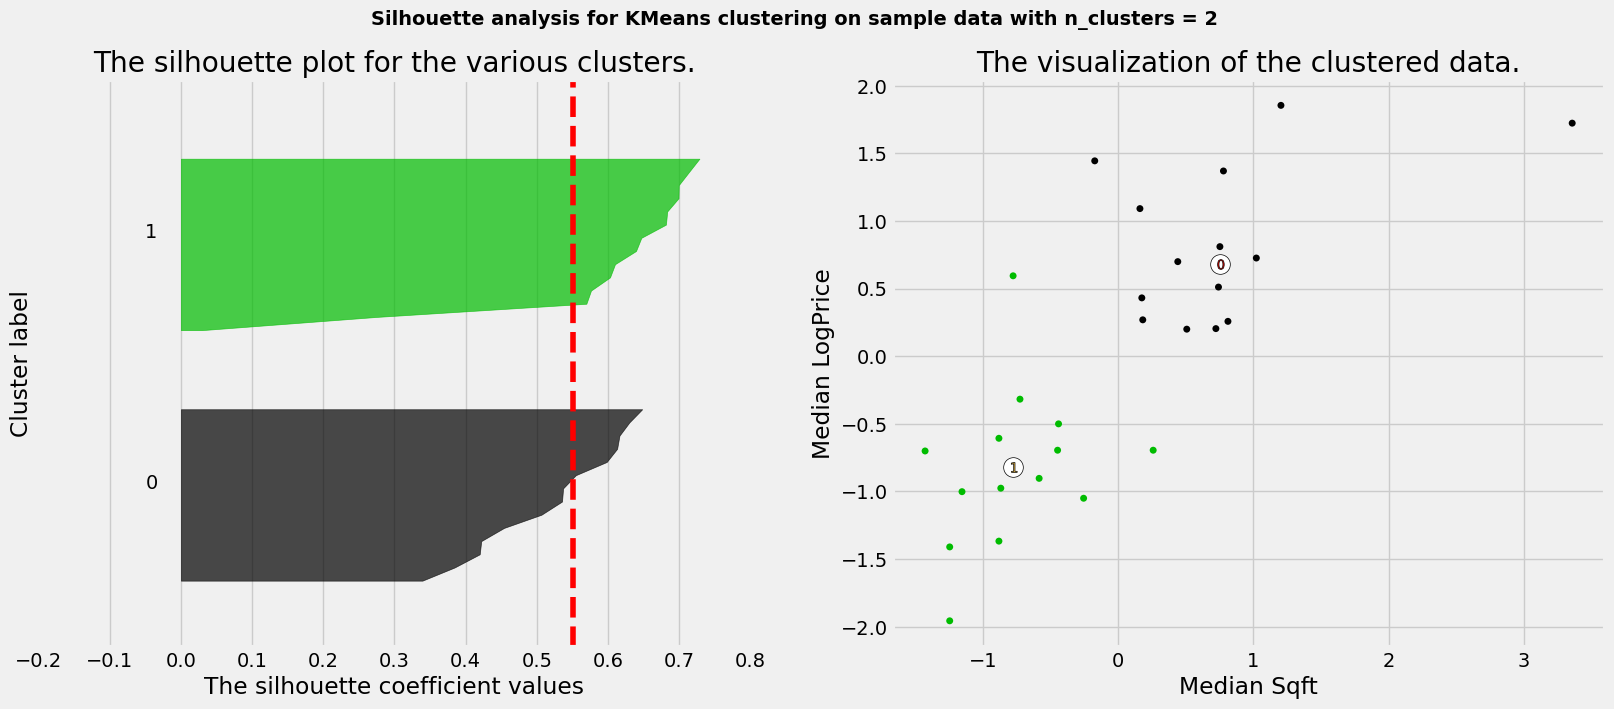

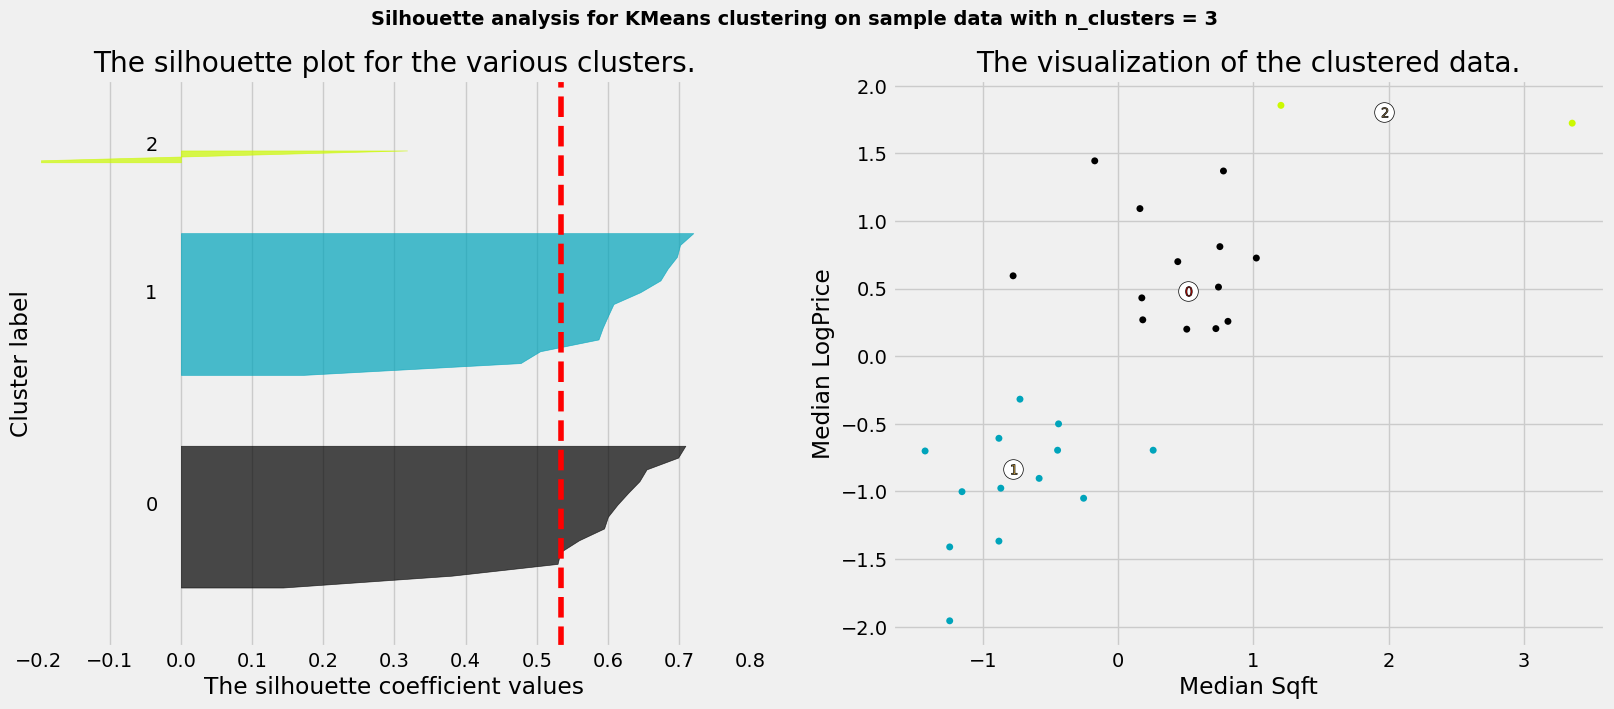

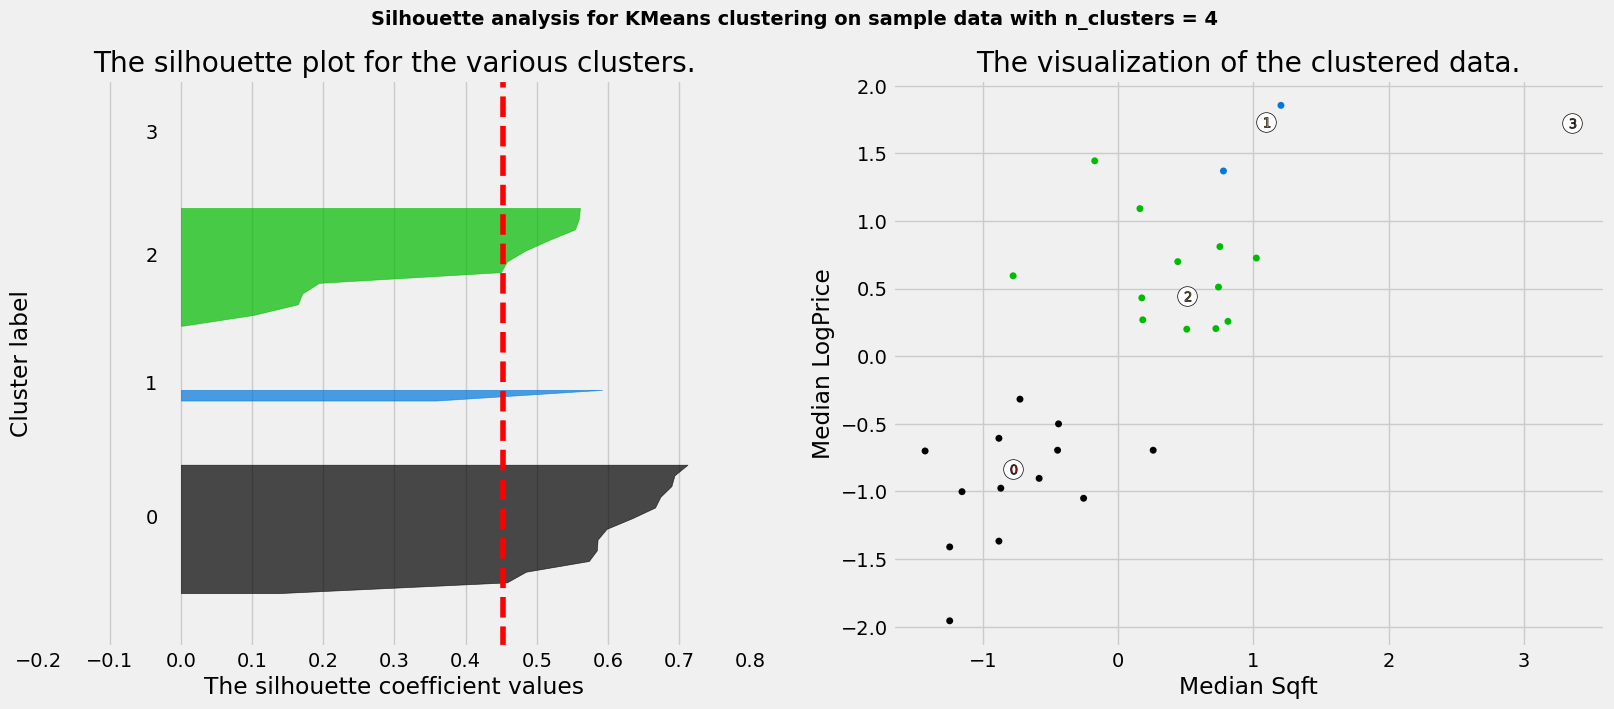

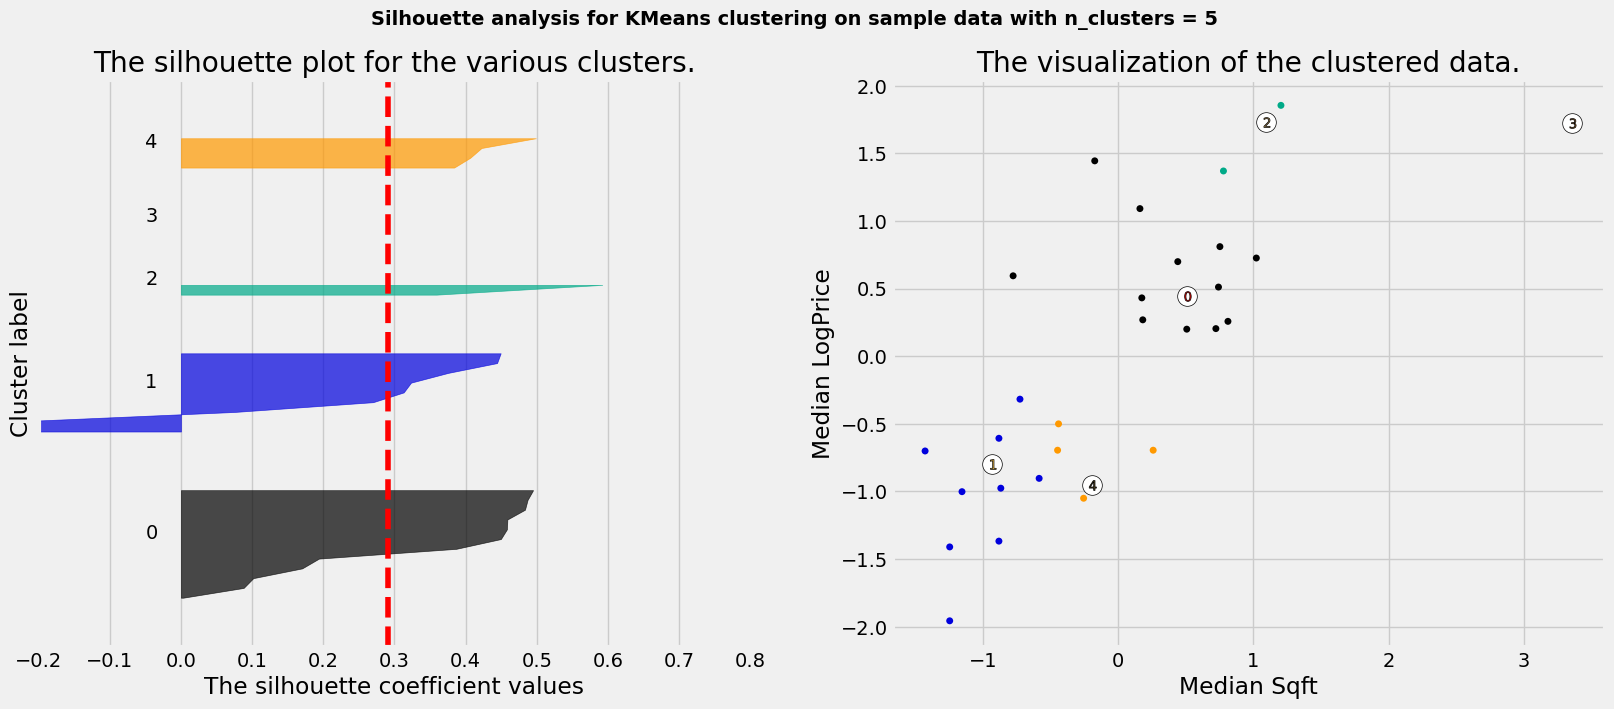

In [17]:
X = nhds
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X, sample_weight=weights)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

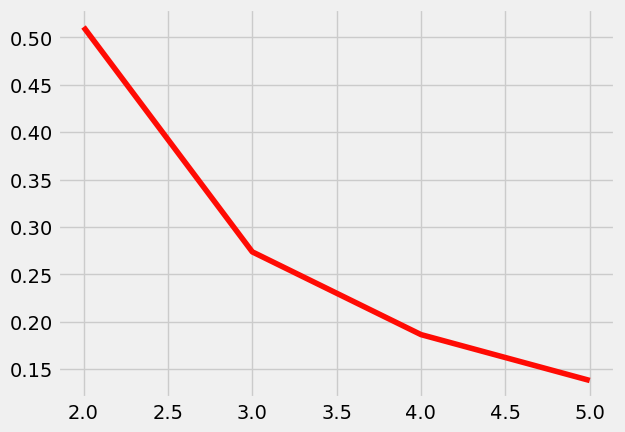

In [18]:
x = range_n_clusters
y = inertias
sns.lineplot(x=x,y=y)
plt.show()

In [19]:
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(X)
nhds['Cluster'] = cluster_labels
nhds.sort_values('Cluster')

,Sqft_med,LogPrice_med,Cluster
Neighborhood,,,
Blmngtn,1500.0,12.142531,0
StoneBr,1670.5,12.501907,0
Somerst,1574.0,12.283034,0
SawyerW,1680.0,12.138864,0
NridgHt,1792.0,12.660328,0
NWAmes,1654.5,12.121323,0
Timber,1663.0,12.319242,0
GrnHill,1398.5,12.526341,0
Greens,1226.0,12.248806,0


In [20]:
cluster_dict = pd.DataFrame(data = {'Nhd_cluster':nhds.Cluster}, index=nhds.index).to_dict()['Nhd_cluster']

In [21]:
train['NhdCluster'] = train.apply(lambda x: cluster_dict[x['Neighborhood']], axis=1)

In [22]:
train.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Prop_Addr,latitude,longitude,NhdCluster
0,535180100,1080,136000,20,RL,75.0,9464,Pave,None,Reg,...,None,0,6,2008,WD,Normal,2001 DOUGLAS AVE,42.042148,-93.612503,1
1,528166060,2392,386250,20,RL,103.0,13472,Pave,None,Reg,...,None,0,6,2009,WD,Normal,3214 HARRISON RD,42.059406,-93.657904,0
2,914465055,1710,240000,20,RL,43.0,12118,Pave,None,IR1,...,None,0,4,2009,WD,Normal,304 TOPAZ CT,41.997137,-93.607203,1
3,923228420,630,81000,180,RM,21.0,1890,Pave,None,Reg,...,None,0,6,2008,WD,Normal,3412 HARCOURT DR,41.991862,-93.603346,1
4,923202060,1771,115000,20,RL,100.0,21750,Pave,None,Reg,...,None,0,11,2009,WD,Normal,3405 EMERALD DR,41.992156,-93.608403,1


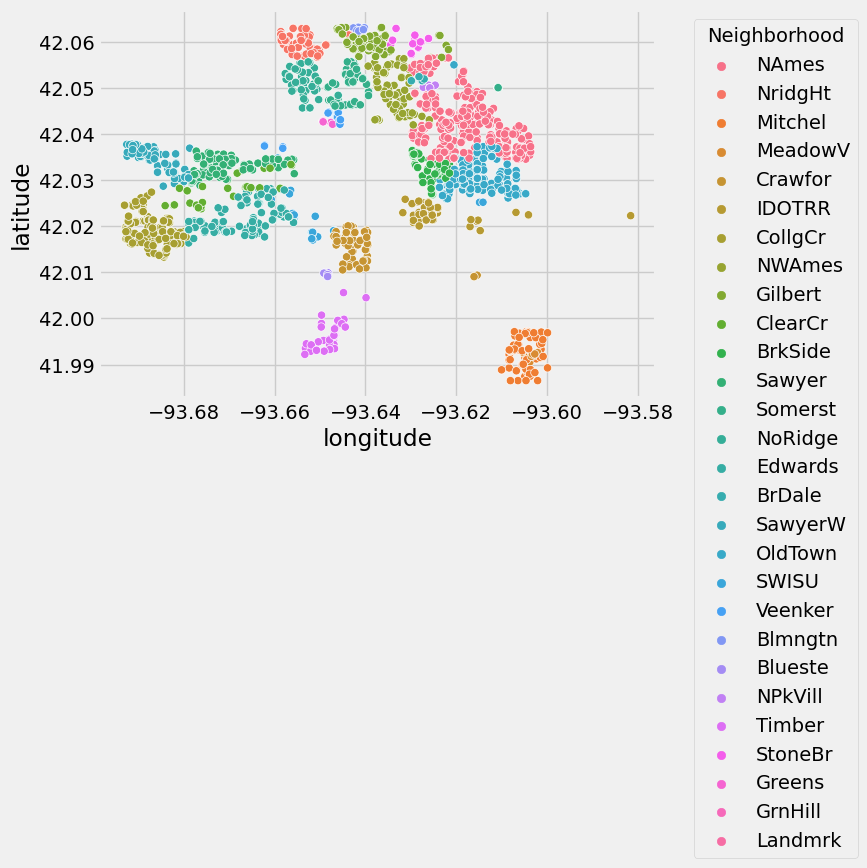

In [29]:
g = sns.scatterplot(data = train, y = 'latitude',x = 'longitude',
                    hue='Neighborhood',)
sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
plt.show()

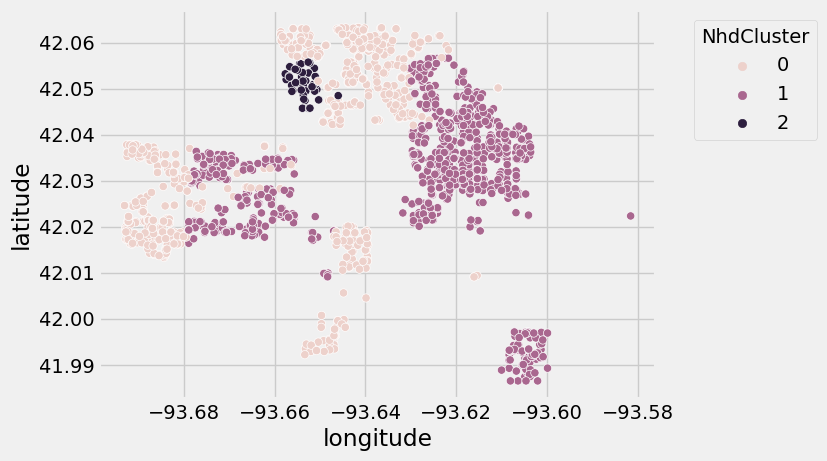

In [30]:
g = sns.scatterplot(data = train, y = 'latitude',x = 'longitude',
                    hue='NhdCluster',)
sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
plt.show()

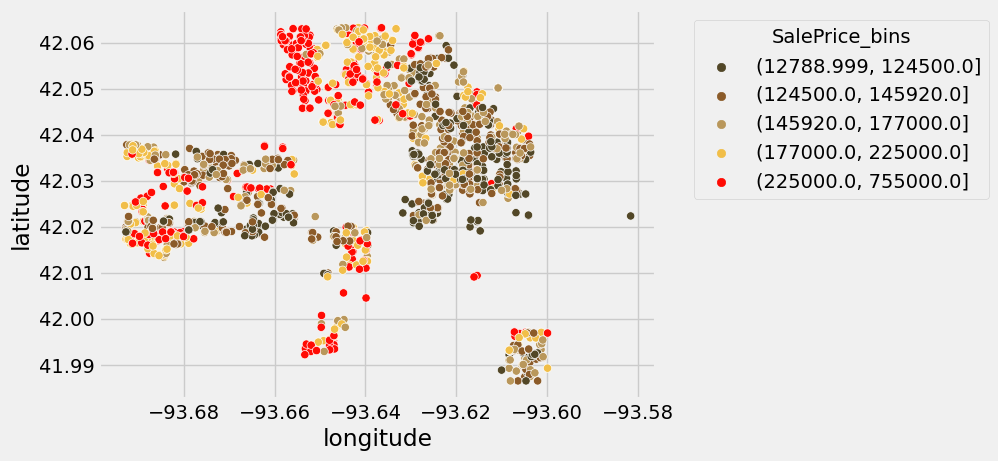

In [33]:
graph_df = train
graph_df['SalePrice_bins'] = pd.qcut(graph_df['SalePrice'],
                              q=5)

g = sns.scatterplot(data = graph_df, y = 'latitude',x = 'longitude',
                    hue='SalePrice_bins',palette = colors[::-1])
sns.move_legend(g,loc = "upper left",bbox_to_anchor=(1.05, 1))
plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
# cats are the above categorical with 'Neighborhood' removed, otherwise
# the ColumnTransformer would have a problem being fed categorical having
# dropped 'Neighborhood' from the features being included in X
cats = ['MSZoning','Street','Alley','LotShape','LandContour','LotConfig',
               'LandSlope','Condition1','Condition2','BldgType','HouseStyle',
               'RoofStyle','Foundation', 'BsmtFinType1','BsmtFinType2','Heating','GarageType',
               'GarageFinish','PavedDrive','MiscFeature','SaleType','SaleCondition',
               'BedroomAbvGr', 'CentralAir'
              ]

In [25]:
clf = LogisticRegression()

In [26]:
train.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC',

In [27]:
# This tries to predict NhdCluster based on features not used in the clustering.
# Wonder if some columns currently being excluded
# could play a role here, like 'Exterior1st', 'Exterior2nd'.
# Scaling the variables has made a huge difference. Now 90% accuracy.
X = train.drop(['SalePrice', 'GrLivArea', 'Neighborhood', 'NhdCluster',],axis=1)
transformer = ColumnTransformer([("Cat", OneHotEncoder(drop='first'), cats)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train['NhdCluster']

clf.set_params(max_iter=1000)
clf.fit(X,y)
clf.score(X,y)

ValueError: could not convert string to float: '2001 DOUGLAS AVE'

In [ ]:
clf.set_params(penalty='l1', C=0.01, random_state=10, solver='saga', max_iter=10000)
selector = SelectFromModel(estimator=clf).fit(X, y)
features = selector.get_support()

In [ ]:
print(len(features))
print(sum(features))

In [ ]:
# These are supposedly the ten most important features for predicting NhdCluster (at least 
# according to one methodology). No longer believe
# this to be useful in feeding into LogSalePrice predicting (let those models choose their own features)
# but is intereting to see for it's own sake. 
X = train.drop(['SalePrice', 'GrLivArea', 'Neighborhood', 'NhdCluster'],axis=1)
transformer = ColumnTransformer([("Cat", OneHotEncoder(drop='first'), cats)], remainder='passthrough')
X = transformer.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X))
rename_dict = dict(zip(pd.DataFrame(X).columns, 
                       transformer.get_feature_names()))
X = pd.DataFrame(X).rename(columns=rename_dict)
X.loc[:,features].columns.to_list()